The first step is always data preparation, in this file we will try to do this
- Our Data (NSynth dataset) is in shambles, so we first need to merge different folders (train, test, validate) into one folder and generate a .csv file that will map each file into a label using examples.json
- After getting our data sorted, we need to see the distribution of classes (how many audio files we have for each label).
- We will then try to visualize our wav files (one file from each label)
    - Time Series
    - Fourier Transformers
    - Filter Bank Coefficient
    - Mel Frequency Cepstrum Coefficient
- After visualizing our data, we can then decide how to normalize it.
    - Remove dead space

In [5]:
import sys
import os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(PROJECT_ROOT)

# Step 1: Generate CSV File

In [2]:
!python ../../utils/generate_audio_csv.py

# Step 2: See Class Distribution

In [10]:
import pandas as pd
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
from config.constants import PROCESSED_AUDIO_DATA_DIR, RAW_AUDIO_DATA_DIR

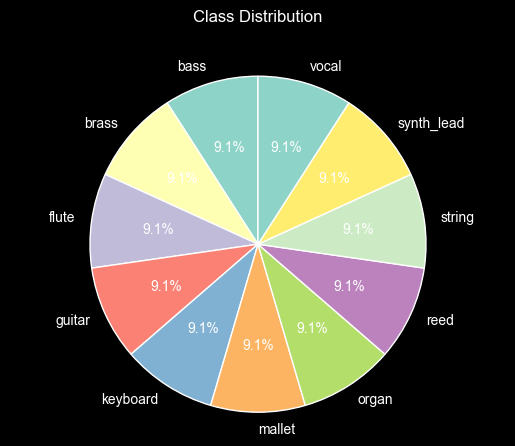

In [11]:
INSTRUMENTS_DIR = PROCESSED_AUDIO_DATA_DIR / 'instruments.csv'
df = pd.read_csv(INSTRUMENTS_DIR)
df.set_index('filename', inplace=True)

# for each wav file, calculate duration
for filename in df.index:
    rate, signal = wavfile.read(RAW_AUDIO_DATA_DIR / filename)
    df.at[filename, 'duration'] = signal.shape[0] / rate  # duration of each wav file in seconds

# extract classes
classes = list(np.unique(df.label))
classes_distribution = df.groupby(['label'])['duration'].mean()

# display distribution as pie chart
fig, axe = plt.subplots()
axe.set_title('Class Distribution', y=1.08)
axe.pie(classes_distribution, labels=classes, autopct='%1.1f%%', shadow=False, startangle=90)
axe.axis('equal')
plt.show()

# return filename to its location
df.reset_index(inplace=True)

# Step 3: Visualize for each label a .wav file

In [3]:
import librosa
from utils.calculate import calc_fft
from python_speech_features import logfbank, mfcc
from utils.plot import plot_everything

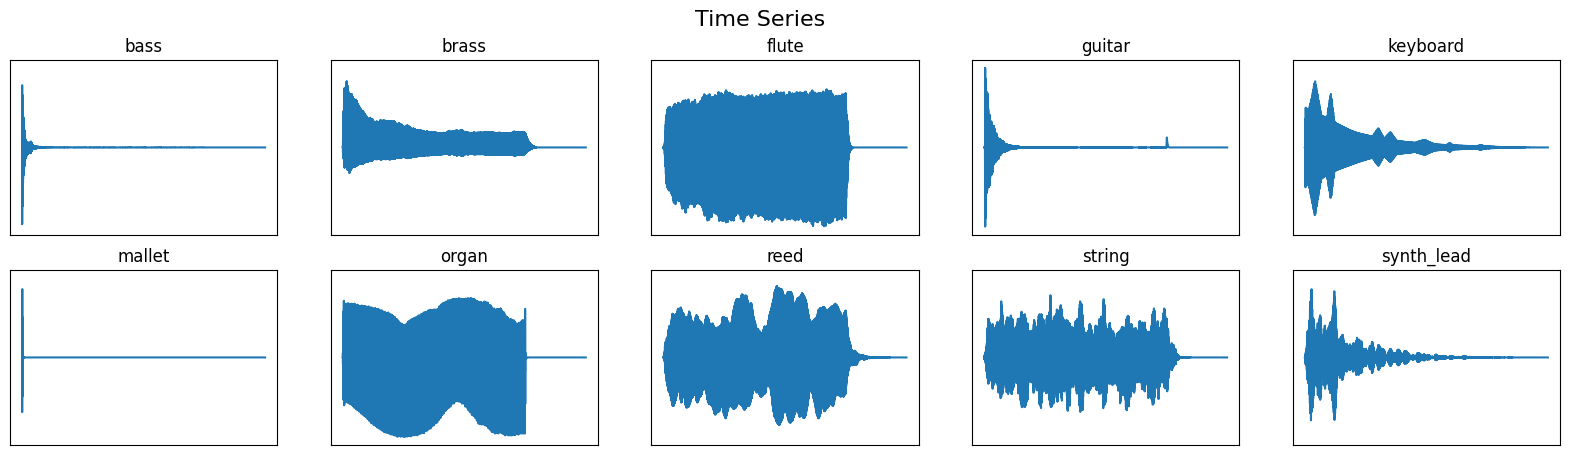

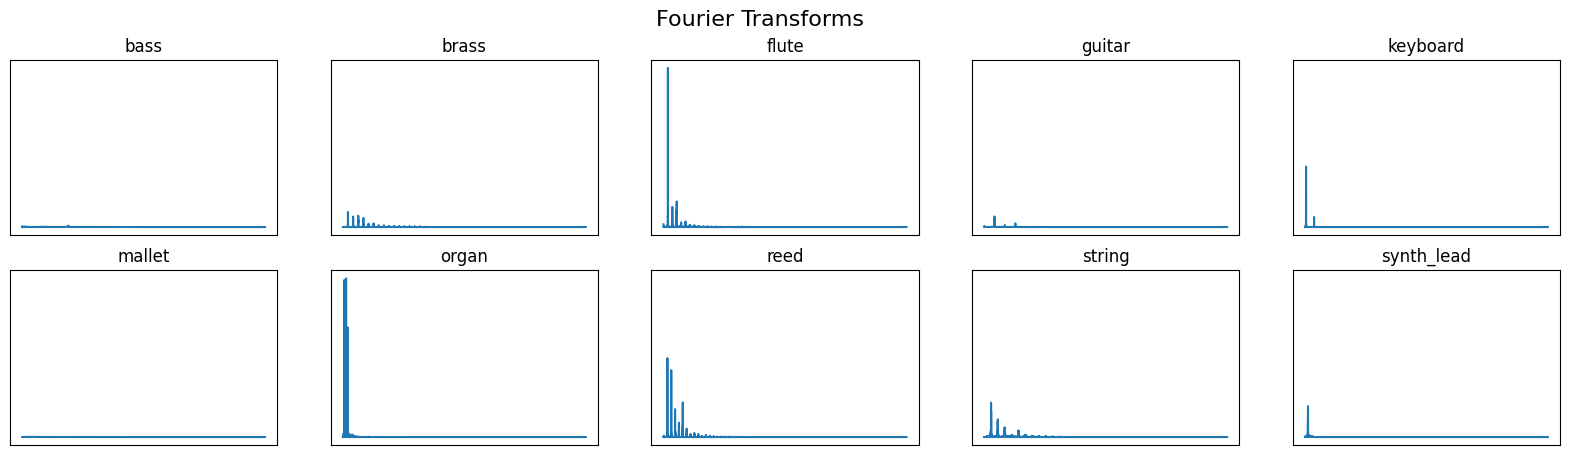

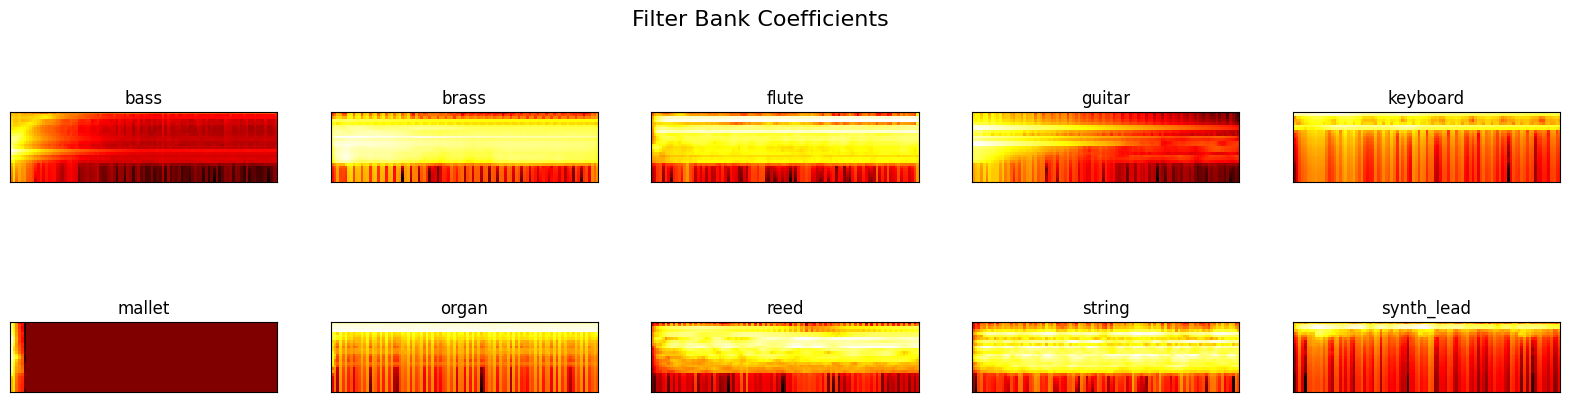

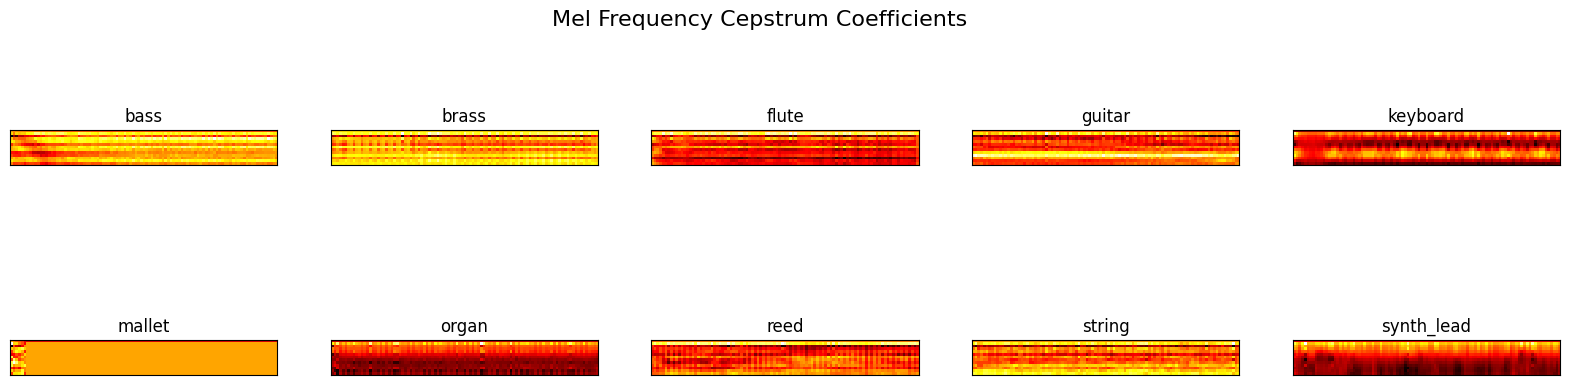

In [5]:
signals = {}
ffts = {}
fbank = {}
mfccs = {}

# visualize
for c in classes:
    wav_file = df[df.label == c].iloc[0, 0]

    signal, rate = librosa.load(RAW_AUDIO_DATA_DIR / wav_file, sr=44100)
    signals[c] = signal

    fft = calc_fft(signal, rate)
    ffts[c] = fft

    bank = logfbank(signal[:rate], rate, nfilt=26, nfft=1103).T
    fbank[c] = bank

    mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T
    mfccs[c] = mel

plot_everything(signals, ffts, fbank, mfccs)

# Step 4: Remove Dead Space

In [ ]:
from utils.normalize import envelope
from config.constants import THRESHOLD

ModuleNotFoundError: No module named 'utils'

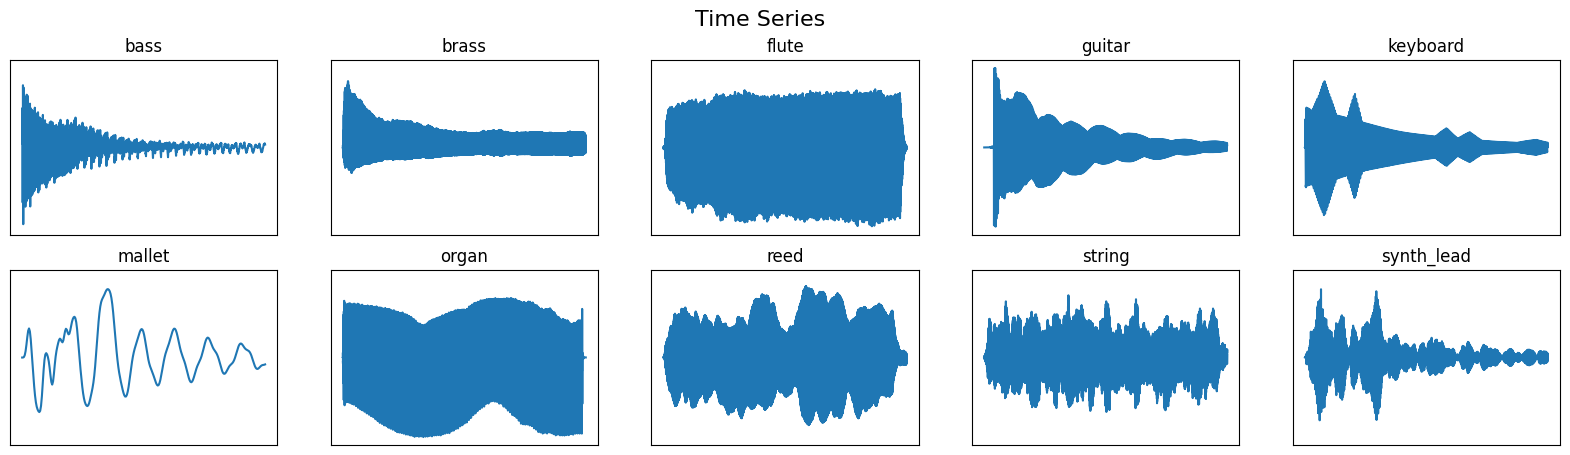

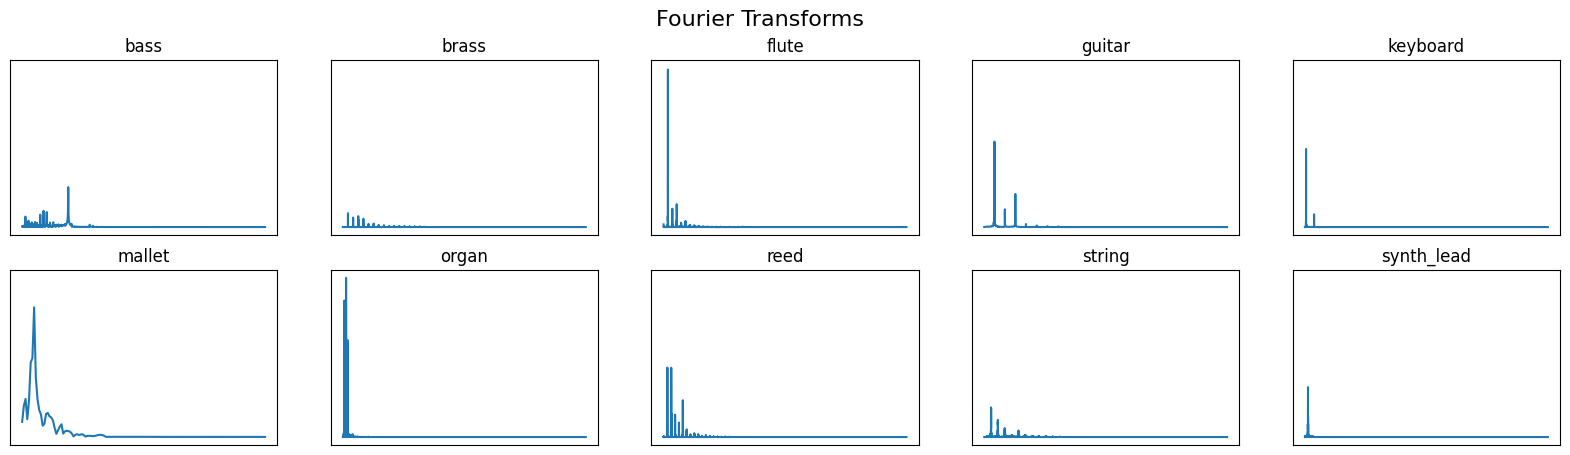

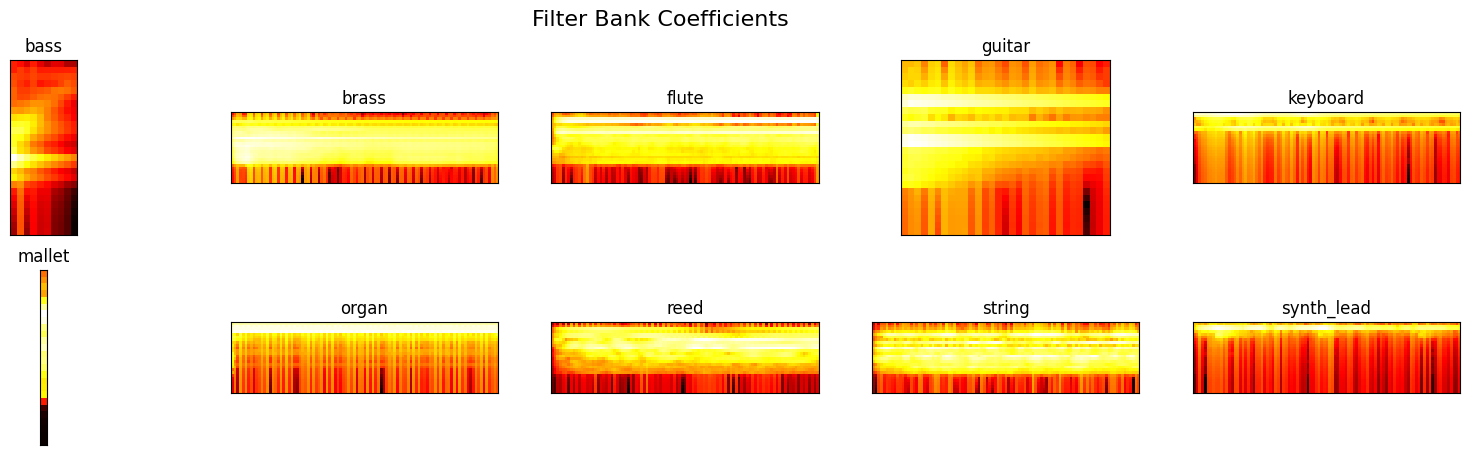

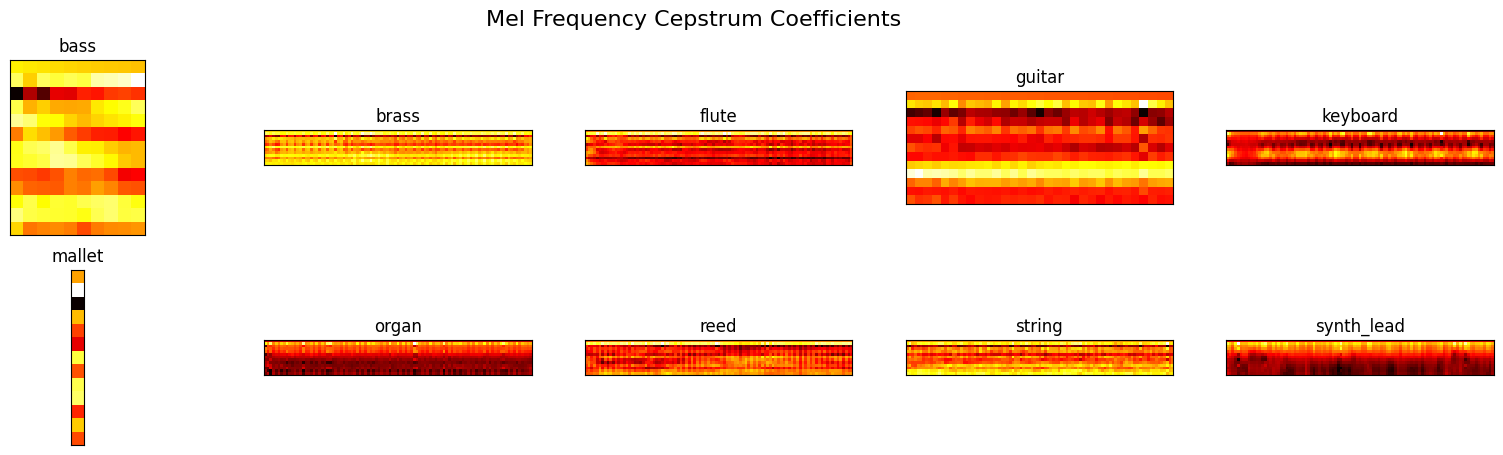

In [ ]:
normalized_signals = {}
normalized_ffts = {}
normalized_fbank = {}
normalized_mfccs = {}

# visualize
for c in classes:
    wav_file = df[df.label == c].iloc[0, 0]

    signal, rate = librosa.load(RAW_AUDIO_DATA_DIR / wav_file, sr=44100)

    # normalize signal
    mask = envelope(signal, rate, THRESHOLD)
    signal = signal[mask]
    normalized_signals[c] = signal

    fft = calc_fft(signal, rate)
    normalized_ffts[c] = fft

    bank = logfbank(signal[:rate], rate, nfilt=26, nfft=1103).T
    normalized_fbank[c] = bank

    mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T
    normalized_mfccs[c] = mel

plot_everything(normalized_signals, normalized_ffts, normalized_fbank, normalized_mfccs)

## Better Comparaison

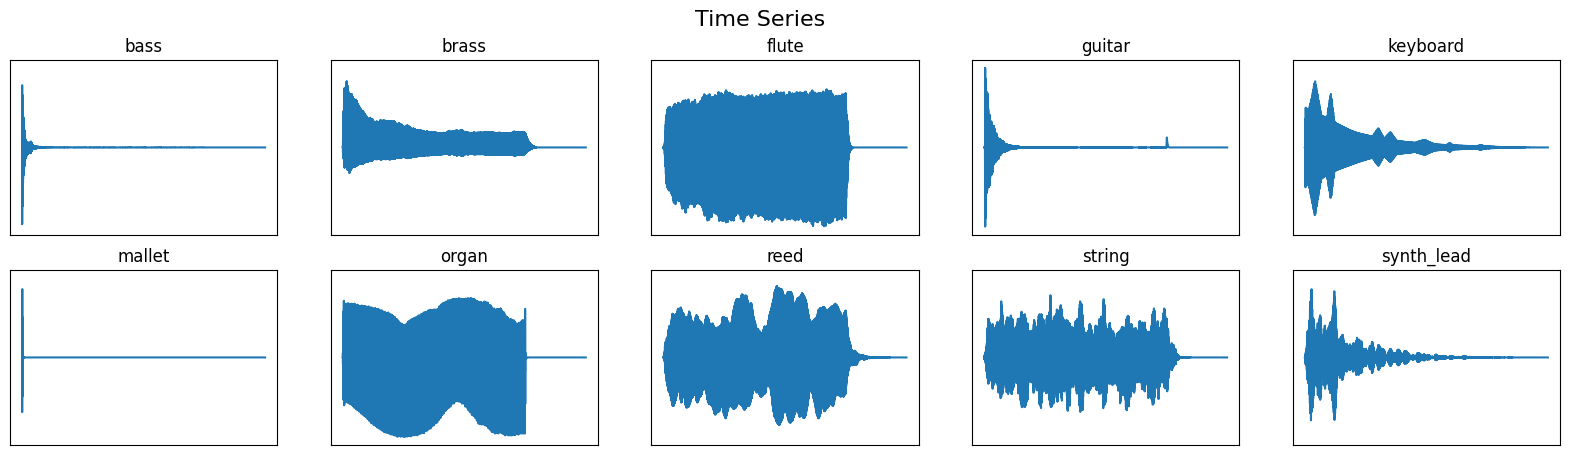

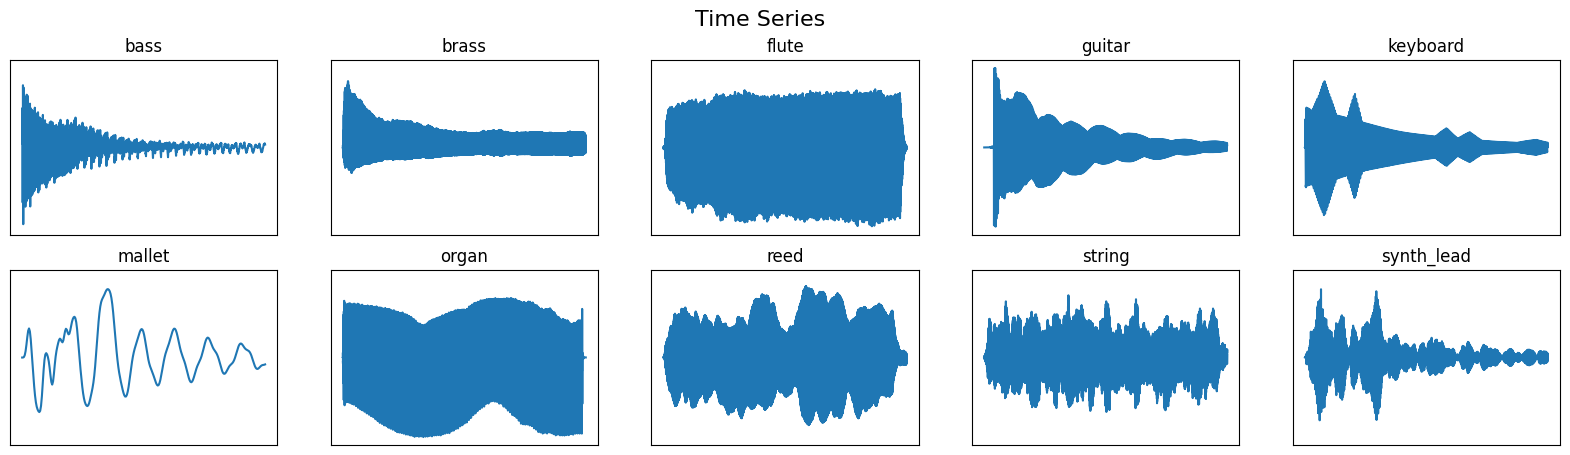

In [12]:
from utils.plot import plot_signals

plot_signals(signals)
plot_signals(normalized_signals)

# Save Clean Data

In [14]:
import os
from tqdm import tqdm
from config.constants import THRESHOLD, CLEANED_AUDIO_DATA_DIR, RAW_AUDIO_DATA_DIR
from utils.normalize import envelope
import librosa

In [15]:
if len(os.listdir(CLEANED_AUDIO_DATA_DIR)) == 0:
    for file in tqdm(df.filename):
        signal, rate = librosa.load(RAW_AUDIO_DATA_DIR / file, sr=16000)
        # Down Sampling
        mask = envelope(signal, rate, THRESHOLD)
        wavfile.write(filename= CLEANED_AUDIO_DATA_DIR / file, rate=rate, data=signal)

100%|██████████| 305979/305979 [40:26<00:00, 126.09it/s] 
